# Lesson 5. Subtract One Raster from Another and Export a New Geotiff in Python

https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/subtract-rasters-in-python/

In [17]:
import os
import numpy as np
import rasterio as rio
from rasterio.plot import plotting_extent
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import seaborn as sns
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

# Get data and set wd
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))


## Open the plot and LIDAR DEM model

In [30]:
# open raster data
with rio.open('data/colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif') as lidar_dem:
    lidar_dem_im = lidar_dem.read(1, masked=True)
    # get bounds for plotting
    bounds = plotting_extent(lidar_dem)

### Import Digital Surface Model (DSM)

Next, you will open the digital surface model (DSM). The DSM represents the top of the earth’s surface. Thus, it includes trees, buildings and other objects that sit on the earth. 

In [31]:
with rio.open('data/colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DSM.tif') as lidar_dsm:
    lidar_dsm_im = lidar_dsm.read(1, masked=True)
    
lidar_dsm_im



masked_array(
  data=[[--, --, --, ..., 1695.6300048828125, 1695.5899658203125,
         1696.3900146484375],
        [--, --, --, ..., 1695.5999755859375, 1695.6300048828125, 1697.0],
        [--, --, --, ..., 1695.3800048828125, 1695.43994140625,
         1695.449951171875],
        ...,
        [--, --, --, ..., 1681.449951171875, 1681.3900146484375, 1681.25],
        [--, --, --, ..., 1681.719970703125, 1681.5699462890625,
         1681.5599365234375],
        [--, --, --, ..., 1681.8900146484375, 1681.8099365234375,
         1681.739990234375]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

# Canopy Height Model

The canopy height model (CHM) represents the HEIGHT of the trees. This is not an elevation value, rather it’s the height or distance between the ground and the top of the trees (or buildings or whatever object that the lidar system detected and recorded).

# Before you subtract the two rasters, be sure to check to see if they cover the same area.

In [20]:
# are the bounds the same?
print("Is the spatial extent the same?", lidar_dem.bounds == lidar_dsm.bounds), 

## is the resolution the same ??
print("Is the resolution the same?", lidar_dem.res == lidar_dsm.res)

Is the spatial extent the same? True
Is the resolution the same? True


In [32]:
# now calculate the canopy height model
# calculate canopy height model
lidar_chm_im = lidar_dsm_im - lidar_dem_im


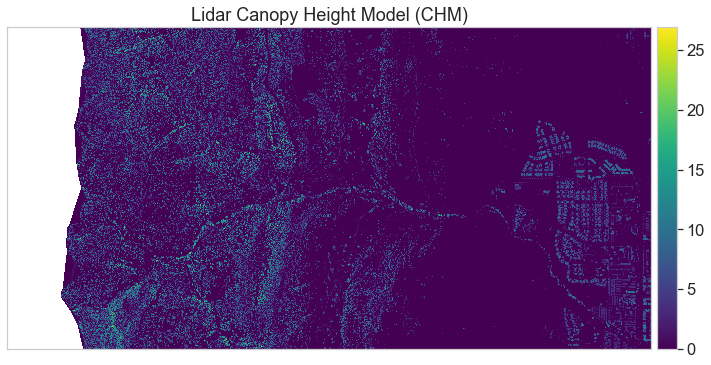

In [22]:
# plot the data
ep.plot_bands(lidar_chm_im, 
              cmap='viridis',
              title="Lidar Canopy Height Model (CHM)",
              scale=False)
plt.show()


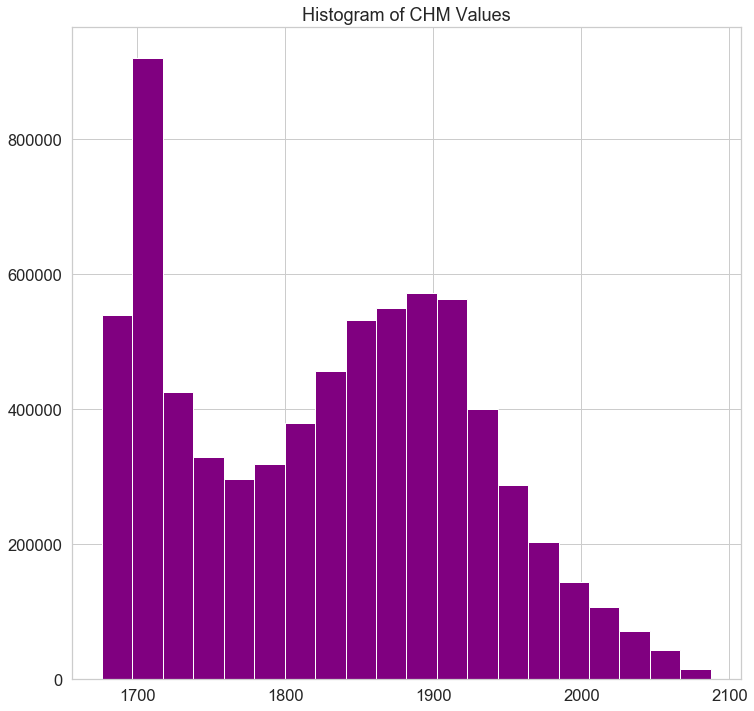

In [23]:
ep.hist(lidar_dem_im[~lidar_dem_im.mask].ravel(), 
        colors = 'purple',
        title="Histogram of CHM Values")
plt.show()


### Explore the CHM Data

Next, explore the data values in your CHM. Think about the values representing things like trees and buildings in your data.

Do the data make sense?

In [33]:
# use python min and max to get lowest and tallest objects
print('CHM minimum value: ', lidar_chm_im.min())
print('CHM max value: ', lidar_chm_im.max())


CHM minimum value:  0.0
CHM max value:  26.930054


## Export a Raster

You can export a raster file in python using the rasterio write() function. Export the canopy height model that you just created to your data folder. You will create a new directory called “outputs” within the colorado-flood directory. This structure allows you to keep things organized, separating your outputs from the data you downloaded.

NOTE: you can use the code below to check for and create an outputs directory. OR, you can create the directory yourself using the finder (MAC) or windows explorer.

In [34]:
if os.path.exists('data/colorado-flood/spatial/outputs'):
    print('The directory exists!')
else:
    os.makedirs('data/colorado-flood/spatial/outputs')


The directory exists!


## Exporting Numpy Arrays to Geotiffs

Next, you need to consider the metdata associated with your chm. Remember that the chm was generated using 2 numpy arrays. Neither of these arrays has spatial data directly associated with it. BUT you do have the rasterio object that has metadata that you can use if you want to assign all of the spatial attributes that are needed to save a usable geotiff file.

In [35]:
lidar_dem.meta


{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 4000,
 'height': 2000,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:32613'),
 'transform': Affine(1.0, 0.0, 472000.0,
        0.0, -1.0, 4436000.0)}

## Next, update the nodata value. The number being used currently is difficult to remember. A more standard value like -999.99 could be a better option. To implement this we will do two things

    You will assign all masked pixels values which represent nodata values to -999.99 using the np.ma.filled() function.
    Then you will create a new metadata dictionary that contained the updated nodata value.

In [36]:
lidar_chm_im.min()
lidar_chm_im

masked_array(
  data=[[--, --, --, ..., 0.0, 0.1700439453125, 0.9600830078125],
        [--, --, --, ..., 0.0, 0.090087890625, 1.6400146484375],
        [--, --, --, ..., 0.0, 0.0, 0.0799560546875],
        ...,
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

In [38]:
# fill the masked pixels with a set no data value
nodatavalue = -999.0
lidar_chm_im_fi = np.ma.filled(lidar_chm_im, fill_value=nodatavalue)
lidar_chm_im_fi.min(), nodatavalue


(-999.0, -999.0)

## Then update the metadata dictionary.

In [39]:
# update the metadata to ensure the nodata value is properly documented 

# create dictionary copy
chm_meta = lidar_dem.meta.copy()
# update the nodata value to be an easier to use number
chm_meta.update({'nodata': nodatavalue})
chm_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -999.0,
 'width': 4000,
 'height': 2000,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:32613'),
 'transform': Affine(1.0, 0.0, 472000.0,
        0.0, -1.0, 4436000.0)}

In [40]:
# note the width and height of the dem above. Is the numpy array shape the same?
lidar_chm_im_fi.shape

(2000, 4000)